In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
a = 17
b = 19
def f(x): 
    return a * x[0] ** 2 + b * (x[0] - x[1]) ** 2 - x[0] - 2 * x[1]
def grad_f(x):
    return np.array([2 * a * x[0] + 2 * b * (x[0] - x[1]) - 1, -2 * b * x[0] + 2 * b * x[1] - 2])
def hessian_f(x, y):
    return np.array([[2 * a + 2 * b, -2 * b], [-2 * b, 2 * b]])
def eig_hessian_f():
    return np.array([-np.sqrt(a ** 2 + 4 * b ** 2) + a + 2 * b, np.sqrt(a ** 2 + 4 * b ** 2) + a + 2 * b])
lambdas = -eig_hessian_f()
lambdas.sort()
lambdas = -lambdas

theta = 1.4
dzeta = 0.2
def func(x):
    return 0.5 * (theta * (x[0] - x[1]) ** 2 + dzeta * (x[0] + x[1]) ** 2)
def animate_trajectory(traj):
    fig, ax = plt.subplots()
    n = len(traj)
    def step(t):
        ax.cla()
        ax.plot([0], [0], 'o', color='green')
        #Level contours
        delta = 0.025
        x = np.arange(-3, 3, delta)
        y = np.arange(-3, 3, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        #print(X.shape, Y.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i][j] = func([X[i][j], Y[i][j]])
        CS = ax.contour(X, Y, Z, [0.5, 1.5, 3], colors=['blue', 'purple', 'red'])
        
        ax.plot([u[0] for u in traj[:t]], [u[1] for u in traj[:t]], color='black')
        ax.plot([u[0] for u in traj[:t]], [u[1] for u in traj[:t]], 'o', color='black')
        
        fix_scaling(ax)
        ax.axis('off')

    return FuncAnimation(fig, step,
                     frames=range(n), interval=600)
def animate_trajectories(traj_array, limit):
    fig, ax = plt.subplots()
    n = limit
    def step(t):
        ax.cla()
        ax.plot([0], [0], 'o', color='green')
        #Level contours
        delta = 0.025
        x = np.arange(-3, 3, delta)
        y = np.arange(-3, 3, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        #print(X.shape, Y.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i][j] = func([X[i][j], Y[i][j]])
        CS = ax.contour(X, Y, Z, [0.5, 1.5, 3], colors=['blue', 'purple', 'red'])
    
        colors = ['black', 'yellow', 'red', 'green']
        i = 0
        for traj in traj_array:
            ax.plot([u[0] for u in traj[:t]], [u[1] for u in traj[:t]], color=colors[i])
            ax.plot([u[0] for u in traj[:t]], [u[1] for u in traj[:t]], 'o', color=colors[i])
            i += 1
        
        fix_scaling(ax)
        ax.axis('off')

    return FuncAnimation(fig, step,
                     frames=range(n), interval=600)
def fix_scaling(ax=None):
    if not ax:
        xlim = plt.xlim()
        ylim = plt.ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            plt.ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            plt.xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))
    else:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            ax.set_ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            ax.set_xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))


In [34]:
def gd_f(x, alpha, limit):
    if (limit == 0): return x
    return gd_f(x - grad_f(x).dot(alpha), alpha, limit - 1)
def gd_f_nonrec(x, limit):
    alpha = (2.0 / (sum(list(eig_hessian_f()))))
    if (limit == 0): return [x]
    traj_opt_step = [x]
    while(limit > 0):
        x = x - grad_f(x).dot(alpha)
        traj_opt_step.append(x)
        limit -= 1
    return traj_opt_step
def heavy_ball_f(x, limit):
    alpha = alpha = 4.0 / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1])) ** 2
    beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
    traj_heavy_ball = []
    x_start = x
    traj_heavy_ball.append(x_start.copy())
    cur_x = x_start.copy()
    prev_x = x_start.copy()
    for i in range(limit):
        t = cur_x
        cur_x = cur_x - alpha * grad_f(cur_x) + beta * (cur_x - prev_x)
        prev_x = t
        traj_heavy_ball.append(cur_x.copy())
    return traj_heavy_ball
def chebyshev(x, limit):
    phi = (lambdas[0] + lambdas[1]) / (lambdas[0] - lambdas[1])
    cur_gamma   = 1.0 / phi
    prev_gamma  = 0
    print(phi - np.sqrt(phi ** 2 - 1))
    print('phi', phi)
    traj_chebyshev = []
    x_start = x
    traj_chebyshev.append(x_start.copy())
    cur_x = x_start.copy()
    prev_x = x_start.copy()
    for i in range(limit):
        t = cur_x
        alpha = 4 * cur_gamma / (lambdas[0] - lambdas[1])
        beta = cur_gamma * prev_gamma
        cur_x = cur_x - alpha * grad_f(cur_x) + beta * (cur_x - prev_x)
        prev_x = t
        t = cur_gamma
        cur_gamma = 1.0 / (2 * phi - cur_gamma)
        prev_gamma = t
        traj_chebyshev.append(cur_x.copy())
#     base_animation = animate_trajectory(traj_chebyshev)
#     HTML(base_animation.to_jshtml())
    return traj_chebyshev
def nesterov(x, limit):
    alpha = 1 / (lambdas[0] + 1)
    beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
    traj_nesterov = []
    x_start = x
    traj_nesterov.append(x_start.copy())
    cur_x = x_start.copy()
    cur_y = x_start.copy()
    
    for i in range(limit):
        t = cur_x
        cur_x = cur_y - alpha * grad_f(cur_y)
        cur_y = cur_x + beta * (cur_x - t)
        traj_nesterov.append(cur_x.copy())
        
#     base_animation = animate_trajectory(traj_nesterov)
#     HTML(base_animation.to_jshtml())
    return traj_nesterov
def gradSolve():
    return np.linalg.solve([[2 * a + 2 * b, -2 * b],[-2 * b,2 * b]], np.array([1,2]))

In [3]:
x = np.array([-100000000,100000000])
limit = 500
f(gd_f_nonrec(x, limit))

array([6.40058292e+17, 1.97963266e+17])

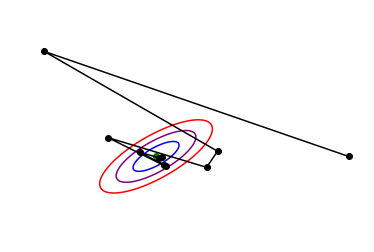

In [4]:
x = np.array([10,0])
lambda1 = lambdas[0]
lambda2 = lambdas[1]
limit = 10
HTML(animate_trajectory(heavy_ball_f(x, limit)).to_jshtml())

0.45774468687729064
phi 1.3211843119531743


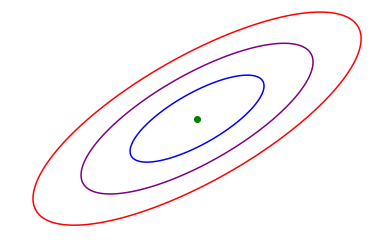

In [5]:
#Chebyshev
phi = (lambdas[0] + lambdas[1]) / (lambdas[0] - lambdas[1])
cur_gamma   = 1.0 / phi
prev_gamma  = 0
print(phi - np.sqrt(phi ** 2 - 1))
print('phi', phi)
traj_chebyshev = []
x_start = np.array([2, 2.8])
traj_chebyshev.append(x_start.copy())
cur_x = x_start.copy()
prev_x = x_start.copy()
for i in range(10):
    t = cur_x
    alpha = 4 * cur_gamma / (lambdas[0] - lambdas[1])
    beta = cur_gamma * prev_gamma
    cur_x = cur_x - alpha * grad_f(cur_x) + beta * (cur_x - prev_x)
    prev_x = t
    t = cur_gamma
    cur_gamma = 1.0 / (2 * phi - cur_gamma)
    prev_gamma = t
#     print('gamma', cur_gamma)
    traj_chebyshev.append(cur_x.copy())
# for i in traj_chebyshev:
#     print(f(i))
#print(traj)
base_animation = animate_trajectory(traj_chebyshev)
HTML(base_animation.to_jshtml())

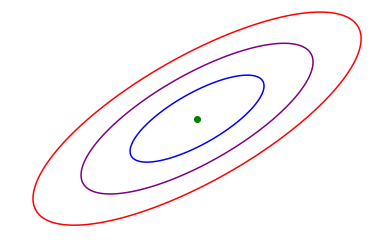

In [6]:
#Nesterov
alpha = 1 / (lambdas[0] + 1)
beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
traj_nesterov = []
x_start = np.array([2, 2.8])
traj_nesterov.append(x_start.copy())
cur_x = x_start.copy()
cur_y = x_start.copy()

for i in range(10):
    t = cur_x
    cur_x = cur_y - alpha * grad_f(cur_y)
    cur_y = cur_x + beta * (cur_x - t)
    traj_nesterov.append(cur_x.copy())
    
base_animation = animate_trajectory(traj_nesterov)
HTML(base_animation.to_jshtml())

In [7]:
f(gradSolve())

-0.18498452012383898

0.45774468687729064
phi 1.3211843119531743


[]

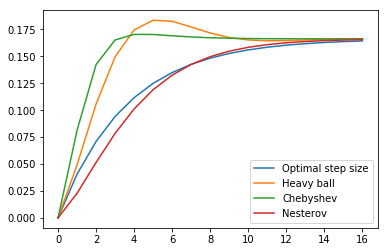

In [29]:
fig, ax = plt.subplots()
x = np.array([0,0])
limit = 16
u = gd_f_nonrec(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t) for t in u], label='Optimal step size')
u = heavy_ball_f(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t) for t in u], label='Heavy ball')
u = chebyshev(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t) for t in u], label='Chebyshev')
u = nesterov(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t) for t in u], label='Nesterov')
plt.legend()
plt.plot()

0.45774468687729064
phi 1.3211843119531743


[]

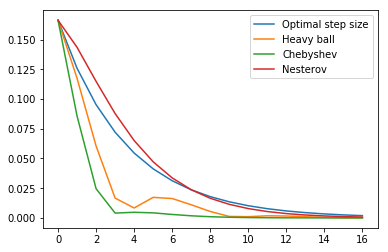

In [28]:
fig, ax = plt.subplots()
x = np.array([0,0])
x0 = gradSolve()
limit = 16
u = gd_f_nonrec(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t - x0) for t in u], label='Optimal step size')
u = heavy_ball_f(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t - x0) for t in u], label='Heavy ball')
u = chebyshev(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t - x0) for t in u], label='Chebyshev')
u = nesterov(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t - x0) for t in u], label='Nesterov')
plt.legend()
plt.plot()

0.45774468687729064
phi 1.3211843119531743


[]

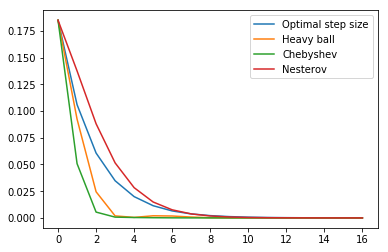

In [27]:
fig, ax = plt.subplots()
x = np.array([0,0])
x0 = gradSolve()
limit = 16
u = gd_f_nonrec(x, limit)
ax.plot(range(limit + 1), [f(t) - f(x0) for t in u], label='Optimal step size')
u = heavy_ball_f(x, limit)
ax.plot(range(limit + 1), [f(t) - f(x0) for t in u], label='Heavy ball')
u = chebyshev(x, limit)
ax.plot(range(limit + 1), [f(t) - f(x0) for t in u], label='Chebyshev')
u = nesterov(x, limit)
ax.plot(range(limit + 1), [f(t) - f(x0) for t in u], label='Nesterov')
plt.legend()
plt.plot()

0.45774468687729064
phi 1.3211843119531743


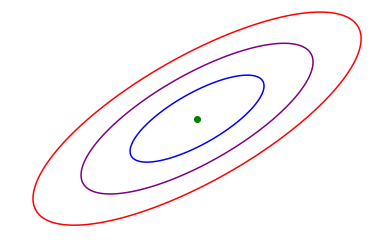

In [70]:
x = np.array([-10,-10])
limit = 16
base_animation = animate_trajectories(np.array([gd_f_nonrec(x, limit), 
                                                heavy_ball_f(x, limit), 
                                                chebyshev(x, limit), 
                                                nesterov(x, limit)]), limit)
HTML(base_animation.to_jshtml())

In [82]:
import math
def f(x): 
    return math.exp(x[0] + 3 * x[1]) + math.exp(x[0] - 3 * x[1]) + math.exp(-x[0])
def grad_f(x):
    return [math.exp(x[0] - 3 * x[1]) + math.exp(x[0] + 3 * x[1]) - math.exp(-x[0]), 
            3 * (math.exp(6 * x[1]) - 1) * math.exp(x[0] - 3 * x[1])]

In [83]:
x = np.array([1,1])
grad_f(x)


[54.36560587520941, 163.38844424972288]